# Bayesian Linear Regression and Posterior Predictive Simulation

## 1. Model Setup 
- Input features 
$X$ (matrix, each row is a data point, each column is a feature)
- Output 
$y$ (vector, e.g., house prices) \
Assume a linear model:

$ y_i = a + b_1 x_{i1} + b_2 x_{i2} + \ldots + b_p x_{ip} + \epsilon_i $ \
where
$
\epsilon_i \sim \mathcal{N}(0, \sigma^2)
$ 

Or, in vector notation:

$
y = a + Xb + \epsilon
$

## 2. Priors
Specify priors for the parameters:

$
a \sim \mathcal{N}(0, 10^2)
$ 

$
b_j \sim \mathcal{N}(0, 10^2)
$

$
\sigma \sim \text{HalfNormal}(2)
$

## 3. Likelihood
The likelihood:

$
y_i \sim \mathcal{N}(a + X_i b, \sigma)
$ \
where 
$X_i$
  is the feature vector for data point 
$i$

## 4. Posterior Sampling
Use MCMC (Markov Chain Monte Carlo) to sample from the posterior distribution of the parameters:

$
p(a, b, \sigma \mid X, y)
$

This gives you many samples (draws) of 
$(a,b,σ)$ that are plausible given the data and priors.

## 5. Posterior Predictive Simulation
For each posterior sample 

$
(a ^{(s)}
 ,b ^{(s)}
 ,σ ^{(s)}
 )$: 

Compute the mean prediction for a new input 
$x^∗$:

$
\mu^{(s)}=a^{(s)} + (x^*)^ \top b^{(s)}
$

Draw a simulated outcome:

$
\tilde{y}^{(s)} \sim \mathcal{N}(\mu^{(s)}, \sigma^{(s)})
$

Repeat for all posterior samples. 

The collection of 
$\tilde{y}^{(s)} $
  values forms the posterior predictive distribution for 
$x^∗$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from bayesian_linear_regression import bayesian_linear_regression_posterior_predictive

sns.set(style="whitegrid")

# Load Ames Housing dataset
data = fetch_openml(name="house_prices", as_frame=True)
df = data.frame

# Use only numeric features for simplicity
numeric_features = df.select_dtypes(include=[np.number]).dropna(axis=1)
X_raw = numeric_features.drop("SalePrice", axis=1).values
y_raw = numeric_features["SalePrice"].values

# Train/Test Split (before standardization)
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.02, random_state=42
)

# Standardize (fit only on train, transform both)
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
y_train_std = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_std = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [2]:
# Run Bayesian linear regression and posterior predictive
y_pred_means_std, y_pred_stds_std, y_pred_samples_std, trace = bayesian_linear_regression_posterior_predictive(
    X_train, y_train_std, X_test, draws=500, tune=500
)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [a, b, sigma]


Output()

Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 37 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


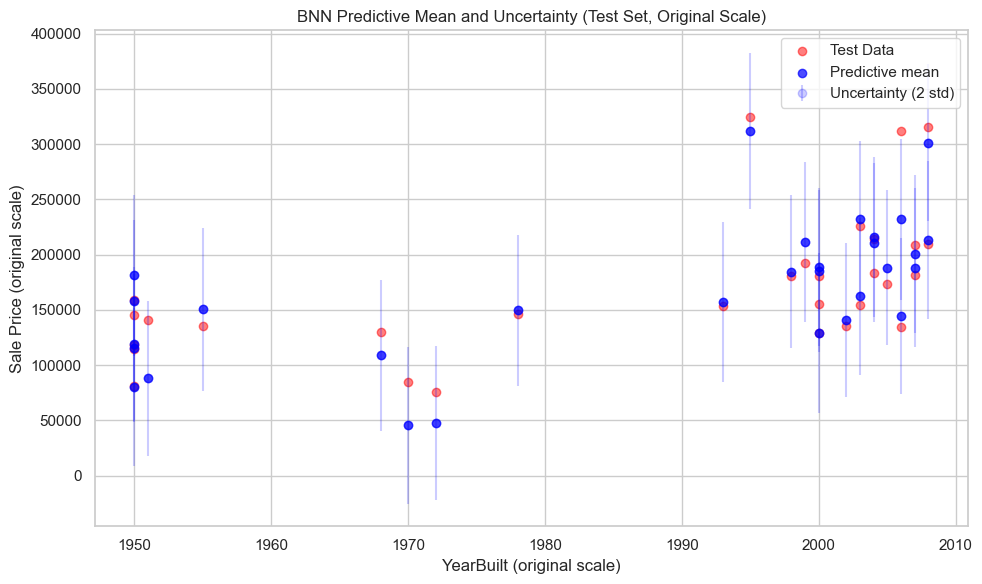

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Chosen feature to plot on the x-axis (e.g., "YearBuilt")
feature_name = "YearBuilt"
feature_idx = list(df.select_dtypes(include=[np.number]).drop("SalePrice", axis=1).columns).index(feature_name)
feature_test = X_test[:, feature_idx]

# Inverse transform predictions, stds, and test values to original scale
y_pred_means = y_scaler.inverse_transform(y_pred_means_std.reshape(-1, 1)).flatten()
y_pred_stds = y_pred_stds_std * y_scaler.scale_[0]  # stds must be rescaled, not inverse_transformed
y_test_orig = y_scaler.inverse_transform(y_test_std.reshape(-1, 1)).flatten()

# Inverse transform the feature to original scale
feature_test_orig = feature_test * X_scaler.scale_[feature_idx] + X_scaler.mean_[feature_idx]

plt.figure(figsize=(10, 6))
# actual test data
plt.scatter(feature_test_orig, y_test_orig, color='red', alpha=0.5, label='Test Data')
# predictive mean
plt.scatter(feature_test_orig, y_pred_means, color='blue', alpha=0.7, label='Predictive mean')
# uncertainty (2 std)
plt.errorbar(feature_test_orig, y_pred_means, yerr=2*y_pred_stds, fmt='o', color='blue', alpha=0.2, label='Uncertainty (2 std)')

plt.xlabel(f'{feature_name} (original scale)')
plt.ylabel('Sale Price (original scale)')
plt.title('BNN Predictive Mean and Uncertainty (Test Set, Original Scale)')
plt.legend()
plt.tight_layout()
plt.show()

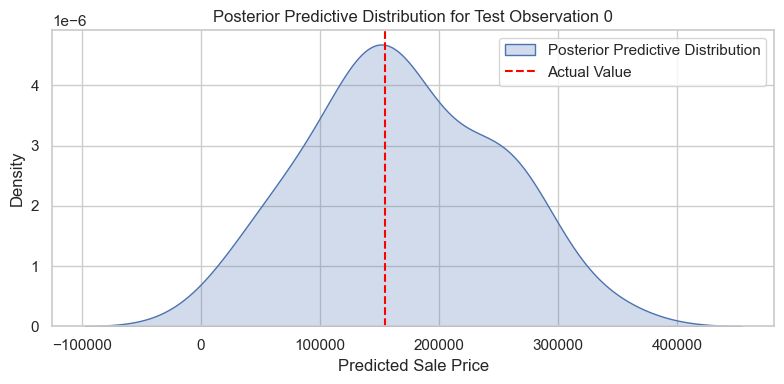

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

idx = 0  # Index of the test observation to visualize

# Get the posterior predictive samples for this observation (in standardized space)
y_pred_obs_std = y_pred_samples_std[:, idx]

# Transform back to original scale
y_pred_obs_orig = y_scaler.inverse_transform(y_pred_obs_std.reshape(-1, 1)).flatten()
y_true_orig = y_scaler.inverse_transform([[y_test_std[idx]]])[0, 0]

# Plot the predictive distribution
plt.figure(figsize=(8, 4))
sns.kdeplot(y_pred_obs_orig, fill=True, label="Posterior Predictive Distribution")
plt.axvline(y_true_orig, color='red', linestyle='--', label="Actual Value")
plt.xlabel("Predicted Sale Price")
plt.ylabel("Density")
plt.title(f"Posterior Predictive Distribution for Test Observation {idx}")
plt.legend()
plt.tight_layout()
plt.show()

# Binary Prediction

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from bayesian_logistic_regression import bayesian_logistic_regression_posterior_predictive

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Select only Versicolor (1) and Virginica (2)
mask = (y == 1) | (y == 2)
X = X[mask]
y = y[mask]
# Relabel: Versicolor=0, Virginica=1
y = (y == 2).astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [21]:
p_pred_means, p_pred_stds, p_pred_samples, trace = bayesian_logistic_regression_posterior_predictive(
    X_train_std, y_train, X_test_std, draws=1000, tune=1000, chains=2, random_seed=42
)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
There were 1103 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


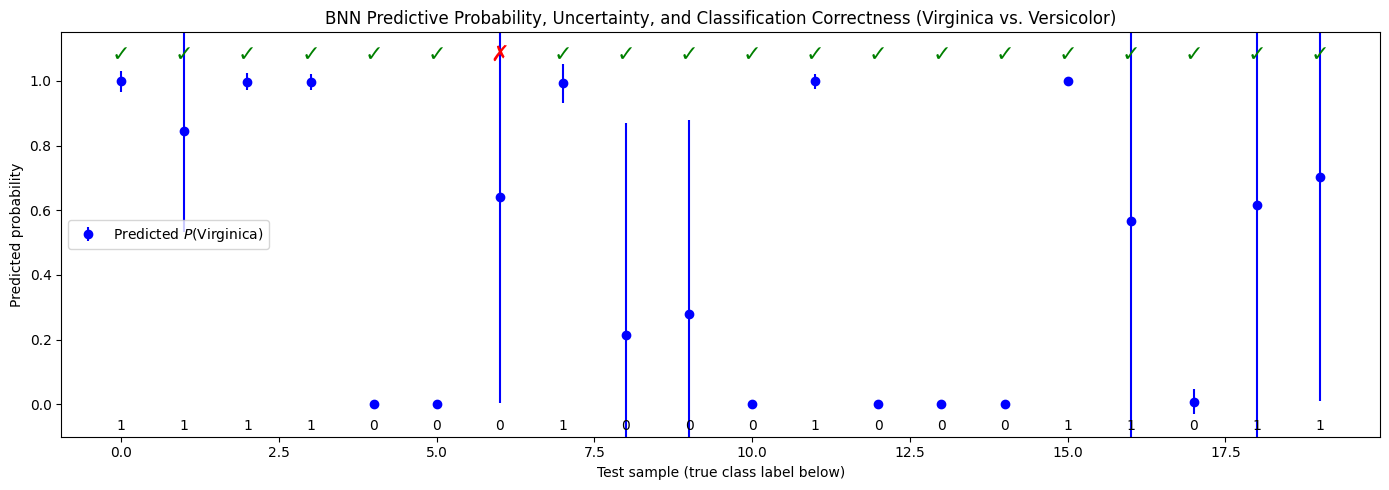

Test accuracy: 0.950


In [22]:
y_pred = (p_pred_means > 0.5).astype(int)
correct = y_pred == y_test

plt.figure(figsize=(14, 5))
x = np.arange(len(y_test))
plt.errorbar(
    x, p_pred_means, yerr=2*p_pred_stds, fmt='o', color='blue', label='Predicted $P$(Virginica)'
)
for i, (yt, yp) in enumerate(zip(y_test, y_pred)):
    color = 'green' if yt == yp else 'red'
    marker = '✓' if yt == yp else '✗'
    plt.text(i, 1.05, marker, color=color, fontsize=16, ha='center', va='bottom', fontweight='bold')
    plt.text(i, -0.08, f"{yt}", color='black', ha='center', fontsize=10)
plt.ylim(-0.1, 1.15)
plt.xlabel("Test sample (true class label below)")
plt.ylabel("Predicted probability")
plt.title("BNN Predictive Probability, Uncertainty, and Classification Correctness (Virginica vs. Versicolor)")
plt.legend()
plt.tight_layout()
plt.show()

accuracy = (y_pred == y_test).mean()
print(f"Test accuracy: {accuracy:.3f}")

# Multiclass Prediction

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from bayesian_multiclass_logistic_regression import bayesian_multiclass_logistic_regression_posterior_predictive

# Load Iris data
iris = load_iris()
X = iris.data
y = iris.target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [8]:
# Bayesian multinomial logistic regression
p_pred_means, p_pred_stds, p_pred_samples, trace = bayesian_multiclass_logistic_regression_posterior_predictive(
    X_train_std, y_train, X_test_std, draws=2000, tune=1000, chains=4, random_seed=42
)

/opt/anaconda3/envs/bnns/lib/python3.13/site-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [coefs, intercept]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


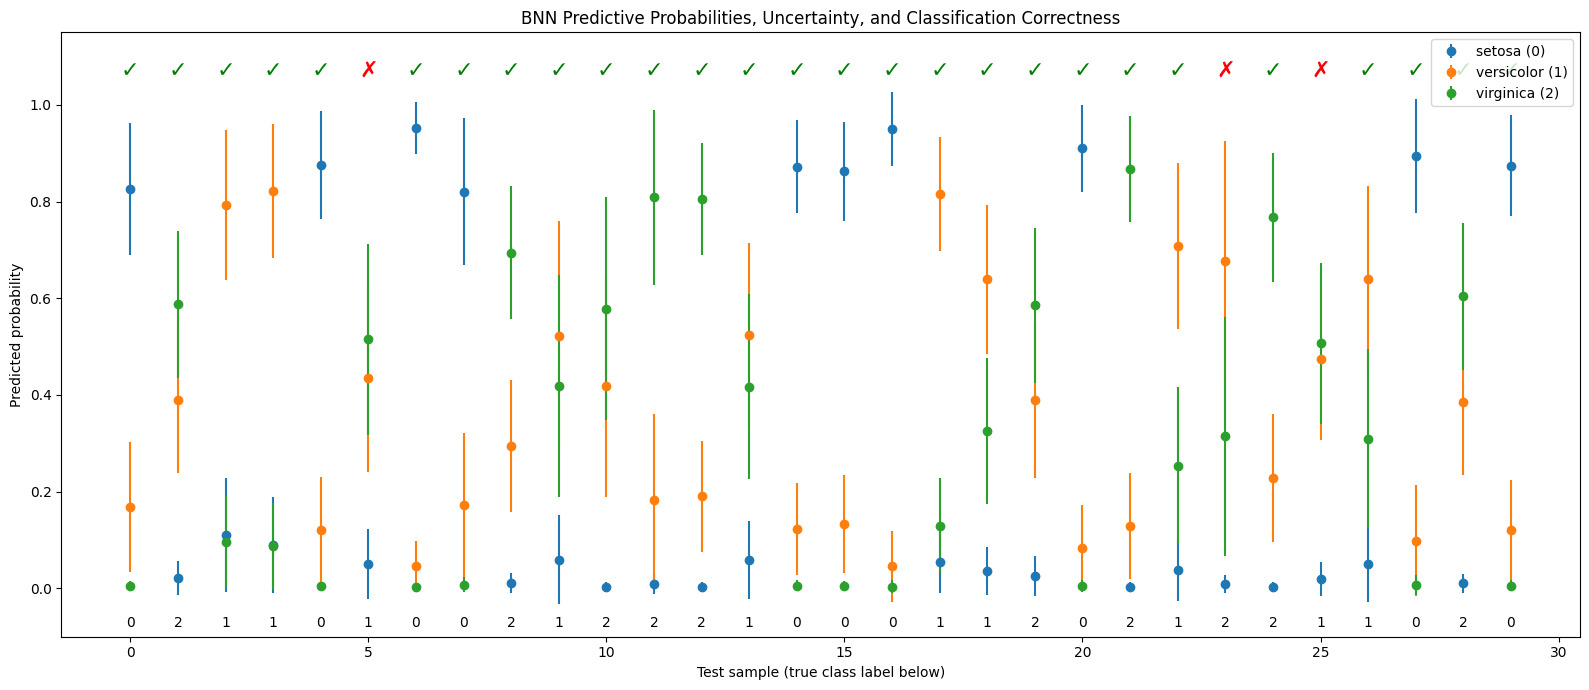

In [9]:
# Predicted class and correctness
y_pred = np.argmax(p_pred_means, axis=1)
correct = y_pred == y_test

# Plot
plt.figure(figsize=(16, 7))
x = np.arange(len(y_test))
class_names = iris.target_names
colors = ['C0', 'C1', 'C2']

for c in range(3):
    plt.errorbar(
        x, p_pred_means[:, c], yerr=2*p_pred_stds[:, c], fmt='o', color=colors[c], label=f'{class_names[c]} ({c})'
    )

# True class labels on x-axis
for i, (yt, yp) in enumerate(zip(y_test, y_pred)):
    color = 'green' if yt == yp else 'red'
    marker = '✓' if yt == yp else '✗'
    plt.text(i, 1.05, marker, color=color, fontsize=16, ha='center', va='bottom', fontweight='bold')
    plt.text(i, -0.08, f"{yt}", color='black', ha='center', fontsize=10)
plt.ylim(-0.1, 1.15)
plt.xlabel("Test sample (true class label below)")
plt.ylabel("Predicted probability")
plt.title("BNN Predictive Probabilities, Uncertainty, and Classification Correctness")
plt.legend()
plt.tight_layout()
plt.show()